# Enron Email Investigation

## Key questions

**_Data for project_** 

The provided dataset is compiled from two sources of Enron company data: financial records for employees, and email exchanges within the company. When combined this gives us a relatively good bredth of features to investigate. As the goal of this project is essentially a simple classification problem - i.e., is a given employee a POI (Person Of Interest), or not - it is particularly well-suited to machine learning, as it can help to identify patterns in the email exchanges etc that can aid in the identification of POIs!  

There were a few outliers that had to be removed prior to the analysis. One was the 'TOTAL' of all employees' financial data, while the other was a travel agency that was listed as an employee. This dataset is also very skewed, many more of one class (non-POI's) than the other (POI's), which can provide certain challenges particularly when trying to validate the chosen models.  

**_Feature selection and performance_**  

A new feature was created - the ratio of an employees stock that was exercised over their total stock allocation. Intuitively I thought that this would provide a good measure of those who knew that the company was struggling or imperiled, and hence sold off their stock before it crashed. If that were the case then it would indicate that such an individual had knowledge of the company's fraudulent activity, and hence may be a POI. I did a quick test of this feature by seeing if the POI/non-POI ratio was different from the population ratio when a cut-off value for the new feature was used. I arbitrarily used 60% as the proportion of stock sold-off as a mark of suspicious activity. While the ratio was higher (18% vs 12.5%), the small sample sizes made for a lot of variance, and so this new feature may or may not be a strong indicator of POI activity. Its true application would need to be assessed as it relates with other features in the dataset. 

Feature-analysis performed using SelectKBest and PCA showed that financial features performed well. The best email-based features appeared to be the 'from_this_person_to_poi' and 'from_poi_to_this_person' ones, which would match well with our expectations. However, given the quite wide feature-space I chose to input all of the available features and then perform a SelectKBest to get the features to use. I ran a GridSearchCV over the range 1 - 19 features, with the search settling on selecting 16 features for the analysis. Scaling was not used as the DecisionTreeClassifier algorithm is not geometrically-dependent.  

**_Choice of algorithm_**

Algorithms attempted include: GaussianNB, DecisionTreeClassifier (DT), SVM, and KNearestNeighbors . After preliminary tests on the dataset with unrefined parameters, the GaussianNB, DT, and KNN algorithms all gave relatively good performance, while the SVM had quite poor performance. For each, the precision/recall values varied strongly depending on the algorithm. I selected to use a DT as *both* the precision and recall values were already >0.3 using unoptimized settings. Also, it has a large number of parameters to 'tune' compared with GaussianNB, allowing the possibility for further improving the metric scores.

**_Parameter tuning_**

Parameter tuning is the practise of tweaking the settings of the classifier algorithm to find the optimum performance. This can be done manually, however it is very difficult to do this in a systematic and/or reproducible way. I used GridSearchCV to automatically test a large parameter-space to find the best-performing parameter settings for my DT classifier. Although using a wide range of parameter values can result in long computational run times, this process can be divided into two steps: coarse tuning, and fine tuning. In the first, a small range of vastly disparate parameter settings are attempted (for parameters with numerical inputs). Next, the search can be performed again on a small range of narrowly dispersed values surrounding the value first found in the coarse tune.

For some parameters, the default settings were found to operate best (e.g. 'max_depth'), and so those were left out from the grid search in subsequent runs. Perhaps the most important parameter that needed to be tuned in this analysis was the 'class_weight', as the default is 'None', but the 'balanced' setting is thought to be much better for skewed classes (such as the POI/non-POI set).  

**_Model validation_**  

Validation is the processing of testing your model on unseen data. If validation is performed on data that was used to train the model, or somehow or another linked to the training data, then 'overfitting' can occur resulting in model outputs with a high variance error.  With small datasets (such as this one) validation can be difficult. The StrattifiedShuffleSplit 'cross-validation' process was therefore employed, as this performs multiple 'folds' of the dataset split randomly into training/testing sets and generates a model based on the averaged results from each fold. Additionally, the 'stratification' refers to each fold containing a representative class balance. This means that for  classification tasks using imbalanced datasets such as this one it accounts for the class imbalance when creating each fold, giving splits with approximately the same ratio of POIs/non-POIs in each fold, and hence ensuring more accurate model predictions. This is important for maximising model validation from a small dataset.  

**_Evaluation metrics_**  

Precision and recall were used as the primary evaluation metrics for this analysis, as these are good for use in cases where the classes are imbalanced. 'Precision' relates to a low 'false positive' rate, while 'recall' relates to a low 'false negative' rate. When tuning the algorithm parameters using the grid search, the 'F1' metric was used as the metric to be optimized during the search, because this is the harmonic mean of precision and recall.  

As the outcome of the final algorithm gave a recall of 0.64, and a precision of 0.34, this indicates that the model is flagging most of the POIs (high RECALL), but also flagging a lot of non-POIs as POIs (low PRECISION). For the context of investigating the Enron employees this situation (i.e. high recall/low precision) may be preferable over the reverse (low precision/high recall), as at least most of the POIs are being flagged. Moreover, non-POIs that have been flagged as POIs can be investigated more closely to determine their true 'classification' before any prosecution is carried out.


# Dataset investigation

### Load data into the 'data_dict' obj

In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'scaled_stock_exercised', 'from_poi_to_this_person', \
 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages', 'from_messages', \
 'deferral_payments', 'total_payments', 'bonus', 'restricted_stock_deferred', 'long_term_incentive', \
 'loan_advances', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', \
 'director_fees', 'restricted_stock']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


/Users/TBD/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


After loading the pickle file into the dictionary 'data_dict', want to check out some characteristics of this 'dict-of-dicts'

### Find number of data points

In [2]:
print len(data_dict)

146


The length of the data_dict dictionary is 146. This is the number of Enron EMPLOYEES that we have (at least partial) data for.

### Example employee entry

In [3]:
print data_dict['RICE KENNETH D']

{'salary': 420636, 'to_messages': 905, 'deferral_payments': 'NaN', 'total_payments': 505050, 'exercised_stock_options': 19794175, 'bonus': 1750000, 'restricted_stock': 2748364, 'shared_receipt_with_poi': 864, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 22542539, 'expenses': 46950, 'loan_advances': 'NaN', 'from_messages': 18, 'other': 174839, 'from_this_person_to_poi': 4, 'poi': True, 'director_fees': 'NaN', 'deferred_income': -3504386, 'long_term_incentive': 1617011, 'email_address': 'ken.rice@enron.com', 'from_poi_to_this_person': 42}


### Find number of features

In [4]:
num_features = 0
# use 'KENNETH D RICE' as example employee
for feature in data_dict['RICE KENNETH D']:
    num_features += 1

print num_features

21


There are 21 features.

### Salary records

In [5]:
# find proportion of employee 'salary' figures for which we have data
count = 0
for employee in data_dict:
    for key in data_dict[employee]:
        if key == 'salary':
            if data_dict[employee][key] != 'NaN':
                count += 1
            #print data_dict[employee][key]

print "No. of Enron employee salaries we have records for:", count
print "Proportion of dataset with salary info:", float(count) / len(data_dict)

No. of Enron employee salaries we have records for: 95
Proportion of dataset with salary info: 0.650684931507


The above indicates that we have salary info for 95 Enron employees, or 65% of total employees.

### Number of POIs/non-POIs in dataset

In [6]:
# find proportion of employee POIs in data set
poi_count = 0
non_poi_count = 0

for employee in data_dict:
    for key in data_dict[employee]:
        if key == 'poi':
            if data_dict[employee][key]:
                poi_count += 1
            else:
                non_poi_count += 1

print "No. of Enron employee who are listed as POIs:", poi_count
print "Total no. of employees:", poi_count + non_poi_count

No. of Enron employee who are listed as POIs: 18
Total no. of employees: 146


Therefore, for our algorithm our 'class alocation' will be skewed. There are 128 non-POIs, and only 18 POIs. This may require special attention or preprocessing during the modelling step.

### Employees flagged as POIs

In [7]:
for employee in data_dict:

    employee_data = data_dict[employee]

    if employee_data["poi"]:
        print employee

HANNON KEVIN P
COLWELL WESLEY
RIEKER PAULA H
KOPPER MICHAEL J
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BOWEN JR RAYMOND M
BELDEN TIMOTHY N
FASTOW ANDREW S
CALGER CHRISTOPHER F
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT
HIRKO JOSEPH
KOENIG MARK E
CAUSEY RICHARD A
GLISAN JR BEN F


We have 18 POIs (i.e. 'poi' = True) in our set of 146 total Enron employees. Note: this is much smaller than the 35 listed in the 'poi_names.txt' file.

### Investigation of feature 'from_poi_to_this_person'

In [8]:
# find proportion of employees that had contact with POIs (i.e. 'from_poi_to_this_person' > 0)
count_nan = 0
count_no_contact = 0
count_contact = 0

for employee in data_dict:
    for key in data_dict[employee]:
        if key == 'from_poi_to_this_person':
            if data_dict[employee][key] == 'NaN':
                count_nan += 1
            elif data_dict[employee][key] == 0:
                count_no_contact += 1
            elif data_dict[employee][key] > 0:
                count_contact += 1
            
print count_nan
print count_no_contact
print count_contact

print "Proportion of non-'NaN' entries for 'from_poi_to_this_person':", (float(count_contact) + count_no_contact) / len(data_dict)

60
12
74
Proportion of non-'NaN' entries for 'from_poi_to_this_person': 0.58904109589


The no. of employees with direct email contact to a POI is 74, while those with no contact at all are only 12 employees. The proportion of employees for with we have data on this is 59%.

### Identification of incorrect data entries

Entries with the value 'NaN' can be handled appropriately by the classifier, however entries listed as 0.0 that should more accurately be 'NaN' will affect the model.

There are only really 2 features for which an entry of 0.0 would be illogical for the given dataset: 'salary' and 'total_payments'. If either of these were truely 0.0 then this person would not be an Enron employee, and therefore may reasonably be removed from the dataset prior to modelling.

If values of 0.0 are found in these features then they may also be transformed to 'NaN' so as to keep the other feature information for that employee.

In [9]:
# search through 'salary' feature looking for entries listed as 0.0
salary_zeros = []
total_payment_zeros = []
salary_nans = []
total_payment_nans = []

for employee in data_dict:
    if data_dict[employee]['salary'] == 0:
        salary_zeros.append(employee)
    if data_dict[employee]['salary'] == 'NaN':
        salary_nans.append(employee)
    if data_dict[employee]['total_payments'] == 0:
        total_payment_zeros.append(employee)
    if data_dict[employee]['total_payments'] == 'NaN':
        total_payment_nans.append(employee)

print "Number of zero-entry salaries:", len(salary_zeros)
print "Number of 'NaN'-entry salaries:", len(salary_nans)

print "Number of zero-entry total_payments:", len(total_payment_zeros)
print "Number of 'NaN'-entry total_payments:", len(total_payment_nans)

Number of zero-entry salaries: 0
Number of 'NaN'-entry salaries: 51
Number of zero-entry total_payments: 0
Number of 'NaN'-entry total_payments: 21


It looks like we don't have any zero-entry datapoints in features for which this would be a concern.

There are however quite a few entries listed as 'NaN' for both 'salary' (51) and 'total_payments' (21). Although this information would be useful to have, the entries do not need to be formatted/processed further before applying the model so they will be left as 'NaN'.

# Feature selection

## 'Manual' feature selection

From intuition, I'd like to initially look at the following list of features:
'poi', 'salary', 'exercised_stock_options', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi'

Also, would like to create a feature based on stock exercised but that is scaled to total_stock_value:
i.e. 

scaled_stock_exercised = exercised_stock_options / total_stock_value

I though this feature might be a good indicator of whether the employee understood the companies precarious position towards the end.

The number of features selected (6) was chosen as I wanted the minimum number of features that represented the data. This could be reduced further by removing tightly-coupled features (for example: from_poi_to_this_person and from_this_person_to_poi).

### Plotting of chosen features

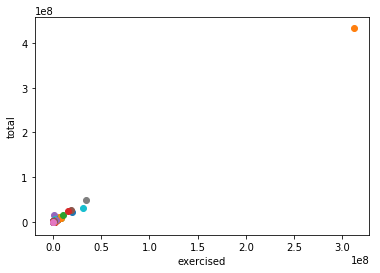

In [10]:
import pickle
import sys
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
import matplotlib.pyplot as plt
%matplotlib inline

features = ["exercised_stock_options", "total_stock_value"]
data = featureFormat(data_dict, features)

for point in data:
    exercised = point[0]
    total = point[1]
    plt.scatter( exercised, total )

plt.xlabel("exercised")
plt.ylabel("total")
plt.show()

There was only one MAJOR outlier observed in the financial features. It appears that this is the entry 'TOTAL'.

As this is not an employee, I'll remove this data point from the dataset prior to analysis.

(see Task 2: Outlier Removal)

## 'Automated' feature selection

Will use univariate feature selection tools from sklearn to automatically screen for the 'k-best' features that most powerfully describe the data.

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif

# list of ALL features
# note: had to remove 'email_address' as it was the only str
features_list = ['poi', 'salary',  'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

### Extract features and labels from dataset for local testing
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# perform feature selection (note: 'f_classif' used as the method to determine 'best' features)
features_clf = SelectKBest(score_func=f_classif, k=6)
features_clf = features_clf.fit(features, labels)

# need to call get_support() to see which features were picked
# created a tuple (using zip()) with the full feature_list to see which we the k-best features (in this case k=6)
print zip(features_clf.get_support(), features_list, features_clf.scores_)

[(False, 'poi', 0.00016005424569618399), (False, 'salary', 0.23899588985313305), (False, 'deferral_payments', 0.34962715304280179), (True, 'total_payments', 2.5182610445203437), (False, 'loan_advances', 0.077948855777229875), (False, 'bonus', 0.0041731922805086684), (False, 'restricted_stock_deferred', 0.21950572394230994), (False, 'deferred_income', 0.16611912320976677), (False, 'total_stock_value', 0.01397841382175243), (False, 'expenses', 0.22826733729104948), (False, 'exercised_stock_options', 0.068194519159558625), (False, 'other', 0.022229270861607336), (False, 'long_term_incentive', 0.031333216297618476), (True, 'restricted_stock', 0.54908420147980874), (True, 'director_fees', 1.7516942790340737), (True, 'to_messages', 5.4466874833253529), (False, 'from_poi_to_this_person', 0.1587702392129193), (True, 'from_messages', 2.470521222656084), (True, 'from_this_person_to_poi', 8.9038215571655712)]


According to the SelctKBest analysis, the 6 best features in the full feature set are: 'total_payments' (2.518), 'restricted_stock' (0.549), 'director_fees' (1.751), 'to_messages' (5.447), 'from_messages' (2.471), and 'from_this_person_to_poi' (8.9034).

It appears that 'from_this_person_to_poi' is the strongest indicator.

These are different from the intuitively-selected features (see above). This difference might have resulted from outliers, or skewed data leading to false trends picked up by the K-Best selector.

I'll run the algorithm using both the 'manually' chosen feature set and this 'automatically' chosen set and compare the performance.

# Removing Outliers

From the above data plotting, and also just looking at the list of employees in the dataset, two potential outliers were identified. These were:

    'TOTAL'
    and
    'THE TRAVEL AGENCY IN THE PARK'

In [12]:
print data_dict['TOTAL']

{'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


In [13]:
print data_dict['THE TRAVEL AGENCY IN THE PARK']

{'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 362096, 'exercised_stock_options': 'NaN', 'bonus': 'NaN', 'restricted_stock': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 362096, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


Both of these entries were removed entirely from the dataset prior to analysis.

In [14]:
# note: as the 'total' column might be useful for some types of analysis, instead of mutating
# the origanal dict I will just create a modified copy of it.
def removeEntry(d, key):
    r = dict(d)
    del r[key]
    return r

new_data_dict = removeEntry(data_dict, 'TOTAL')
new_data_dict = removeEntry(new_data_dict, 'THE TRAVEL AGENCY IN THE PARK')

In [15]:
print len(new_data_dict)

144


# Coding up new features

### scaled_stock_exercised

In [17]:
### Write func to generically return the 'scaled' stock exercised
def scaledStock(exercised, total):
    """
    Compute the fraction of exercised stock options from the 'total stock' for a given employee.
    Takes two features: the 'exercised_stock_options' and 'total_stock_value' and returns a single float.
    
    i.e. scaledStock(Int, Int) --> Float
    """
    if (exercised == "NaN") or (total == "NaN"):
        scaled_stock_exercised = "NaN"
    elif exercised / total == 1:
        scaled_stock_exercised = "NaN"
    else:
        scaled_stock_exercised = float(exercised) / total
            
    return scaled_stock_exercised


### Perform scaling computation on Enron dataset and add as a new feature (i.e. a new
### 'key' in the employee dict called 'scaled_stock_exercised')
for employee in new_data_dict:

    employee_data = new_data_dict[employee]
    exercised_stock_options = employee_data["exercised_stock_options"]
    total_stock_value = employee_data["total_stock_value"]
    scaled_stock_exercised = scaledStock( exercised_stock_options, total_stock_value )
    # print scaled_stock_exercised
    employee_data["scaled_stock_exercised"] = scaled_stock_exercised

The initial code for the scaledStock() function gave mostly reasonable values. However, there were a significant amount of entries of '1.0', which seems unlikely (i.e. that an employee sold ALL of the stock). There were also a few NEGATIVE values, which doesn't make much sense. Values of '0.0' are ok, as this was the default for if there was no entry for either 'exercised_stock_options' or 'total_stock_value' (i.e. 'NaN') but also might represent an employee who did not own any stock.

Will try investigate the cases of scaled_stock_exercised = 1.0 more closely.

### First, will find the negative entry!

In [18]:
for employee in new_data_dict:

    employee_data = new_data_dict[employee]

    if employee_data["scaled_stock_exercised"] < 0:
        print employee

BELFER ROBERT


Seems to be just 'Robert Belfer'. If we print out his full entry we can see that his 'total_stock_value' is listed as -44093. This seems to be a data entry error, but unsure of the exact cause so will remove this employee from the dataset as the negative salary may affect other analyses. Also, given than most of his entries are 'NaN' this should not affect the dataset too much

In [19]:
print data_dict['BELFER ROBERT']

{'to_messages': 'NaN', 'deferral_payments': -102500, 'expenses': 'NaN', 'poi': False, 'deferred_income': 'NaN', 'email_address': 'NaN', 'long_term_incentive': 'NaN', 'restricted_stock_deferred': 44093, 'shared_receipt_with_poi': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'director_fees': 3285, 'bonus': 'NaN', 'total_stock_value': -44093, 'from_poi_to_this_person': 'NaN', 'scaled_stock_exercised': -0.07450162157258522, 'from_this_person_to_poi': 'NaN', 'restricted_stock': 'NaN', 'salary': 'NaN', 'total_payments': 102500, 'exercised_stock_options': 3285}


In [20]:
### A COPY made of the dictionary with Robert Belfer's entry deleted to avoid mutating the original dataset
def removeEmployee(d, key):
    r = dict(d)
    del r[key]
    return r

new_data_dict = removeEmployee(new_data_dict, 'BELFER ROBERT')

### Now look at entries with scaled_stock_exercised = 1.0

In [21]:
for employee in new_data_dict:

    employee_data = new_data_dict[employee]

    if employee_data["scaled_stock_exercised"] == 1.0:
        # print new_data_dict[employee]
        print employee, ":", "Exercised:", new_data_dict[employee]['exercised_stock_options'], "Total:", new_data_dict[employee]['total_stock_value']

There are 24 employees whom exercised ALL of their stock. However, only one of these is listed as a POI ('HIRKO JOSEPH') and there is nothing overly suspicious of the others.

They may simply have left Enron early and cashed in all of the stock, or needed to for some other reason.

Solution: When performing the algorithm training, 'scaled_stock_exercised' values of 0.0 and 1.0 will be excluded to avoid any skewing effect, as these entries can be reasonably argued to be not informative in the search for fraud connections.

This was acheived by re-writing the original feature-generating code so that values of 0.0 and 1.0 were set to "NaN"

## New feature check

Just to see if the new feature ('scaled_stock_exercised') was actually of interest I printed out the names of the list of POI's for whom the percentage of their stock they sold off was >60%.

In [22]:
for employee in new_data_dict:

    employee_data = new_data_dict[employee]

    if employee_data["scaled_stock_exercised"] >= 0.6 and employee_data["scaled_stock_exercised"] != "NaN" \
    and employee_data["poi"]:
        print employee

HANNON KEVIN P
RIEKER PAULA H
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BELDEN TIMOTHY N
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT


In [26]:
for employee in new_data_dict:
    employee_data = new_data_dict[employee]
    # print employee_data["scaled_stock_exercised"]

In [29]:
count_sus = 0
count_pop = 0
for employee in new_data_dict:

    employee_data = new_data_dict[employee]

    if employee_data["scaled_stock_exercised"] >= 0.6 and employee_data["scaled_stock_exercised"] != "NaN" \
    and employee_data["poi"]:
        count_sus += 1
    
    if employee_data["scaled_stock_exercised"] >= 0.6 and employee_data["scaled_stock_exercised"] != "NaN":
        count_pop += 1

print "Ratio of POIs who sold >60% of their stock:", float(count_sus) / count_pop
print "Ratio in whole population:", float(18) / 144

Ratio of POIs who sold >60% of their stock: 0.18
Ratio in whole population: 0.125


The ratio of POIs/non-POIs who sold off a lot of their stock isn't significantly different from that of the whole population (18% vs 12.5%). It is also a **very** small sample size, so will have a large vairance. 

The new 'scaled_stock_exercised' feature, therefore, may not be a strong indicator of POIs.

# Algorithm Selection

Choice of classifier algorithms to use include:

    - Gaussian Naive-Bayes (GuassianNB)
    - Decision Tree (DT)
    - SVM
    - K-Nearest Neighbors (KNN)
    
For each, will use SelectKBest to scan over entire feature-space (19 features). Will apply scaling where appropriate, but no other parameter tuning will be used.

In [30]:
### Store to my_dataset for easy export below.
# my_dataset = data_dict 	# use updated dict instead
my_dataset = new_data_dict

features_list = ['poi',
                 'salary', 
                 'scaled_stock_exercised', 
                 'from_poi_to_this_person', 
                 'from_this_person_to_poi', 
                 'shared_receipt_with_poi', 
                 'to_messages', 
                 'from_messages',
                 'deferral_payments', 
                 'total_payments', 
                 'bonus', 
                 'restricted_stock_deferred', 
                 'long_term_incentive', 
                 'loan_advances', 
                 'deferred_income', 
                 'total_stock_value', 
                 'expenses', 
                 'exercised_stock_options',
                 'director_fees', 
                 'restricted_stock'
                ]

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Import necessary modules

In [31]:
# import relevant modules
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from time import time

from tester import test_classifier

## Gaussian NB model

In [32]:
from sklearn.naive_bayes import GaussianNB

t0 = time()

scaler = MinMaxScaler()
kbest = SelectKBest()
cv = StratifiedShuffleSplit(labels,1000,random_state=42)
clf_nb = GaussianNB()
pipe = Pipeline([('scaling',scaler),('kbest',kbest),('gnb',clf_nb)])
parameters = {'kbest__k':range(1,19)}

gs = GridSearchCV(pipe,param_grid=parameters,cv=cv, scoring='f1')
gs.fit(features,labels)
clf = gs.best_estimator_
test_classifier(clf, new_data_dict, features_list, folds=1000)

print "Time taken:", (time() - t0)

/Users/TBD/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/TBD/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [12] are constant.
  UserWarning)
/Users/TBD/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=14, score_func=<function f_classif at 0x113724a28>)), ('gnb', GaussianNB(priors=None))])
	Accuracy: 0.77460	Precision: 0.26991	Recall: 0.40500	F1: 0.32394	F2: 0.36815
	Total predictions: 15000	True positives:  810	False positives: 2191	False negatives: 1190	True negatives: 10809

Time taken: 141.937551022


### GaussianNB results:

    Accuracy: 0.77460
    Precision: 0.26991
    Recall: 0.40500
    F1: 0.32394
    k = 16

## Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier

t0 = time()

kbest = SelectKBest()
cv = StratifiedShuffleSplit(labels,1000,random_state=42)
clf_dt = DecisionTreeClassifier()
pipe = Pipeline([('kbest',kbest),('dt',clf_dt)])
parameters = {'kbest__k':range(1,19)}

gs = GridSearchCV(pipe,param_grid=parameters,cv=cv, scoring='f1')
gs.fit(features,labels)
clf = gs.best_estimator_
test_classifier(clf, new_data_dict, features_list, folds=1000)

print "Time taken:", (time() - t0)

Pipeline(steps=[('kbest', SelectKBest(k=3, score_func=<function f_classif at 0x113724a28>)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.81440	Precision: 0.32406	Recall: 0.36100	F1: 0.34153	F2: 0.35295
	Total predictions: 15000	True positives:  722	False positives: 1506	False negatives: 1278	True negatives: 11494

Time taken: 147.122808933


### Decision Tree Results:

    Accuracy: 0.81440
    Precision: 0.32406
    Recall: 0.36100
    F1: 0.34153
    k = 3

## SVM Classifier

In [35]:
from sklearn.svm import SVC
t0 = time()

scaler = MinMaxScaler()
kbest = SelectKBest()
cv = StratifiedShuffleSplit(labels,1000,random_state=42)
clf_svm = SVC()
pipe = Pipeline([('scaling',scaler),('kbest',kbest),('svc',clf_svm)])
parameters = {'kbest__k':range(1,19)}

gs = GridSearchCV(pipe,param_grid=parameters,cv=cv, scoring='f1')
gs.fit(features,labels)
clf = gs.best_estimator_
test_classifier(clf, new_data_dict, features_list, folds=1000)

print "Time taken:", (time() - t0)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=1, score_func=<function f_classif at 0x113724a28>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86667	Precision: 0.50000	Recall: 0.04150	F1: 0.07664	F2: 0.05082
	Total predictions: 15000	True positives:   83	False positives:   83	False negatives: 1917	True negatives: 12917

Time taken: 181.322751999


### SVM Results

    Accuracy: 0.86667
    Precision: 0.50000
    Recall: 0.04150
    F1: 0.07664
    k = 1

## KNearestNeighbors Classifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier

t0 = time()

scaler = MinMaxScaler()
kbest = SelectKBest()
cv = StratifiedShuffleSplit(labels,1000,random_state=42)
clf_knn = KNeighborsClassifier()
pipe = Pipeline([('scaling',scaler),('kbest',kbest),('knn',clf_knn)])
parameters = {'kbest__k':range(1,19)}

gs = GridSearchCV(pipe,param_grid=parameters,cv=cv, scoring='f1')
gs.fit(features,labels)
clf = gs.best_estimator_
test_classifier(clf, new_data_dict, features_list, folds=1000)

print "Time taken:", (time() - t0)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=3, score_func=<function f_classif at 0x113724a28>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
	Accuracy: 0.87840	Precision: 0.64058	Recall: 0.20050	F1: 0.30541	F2: 0.23244
	Total predictions: 15000	True positives:  401	False positives:  225	False negatives: 1599	True negatives: 12775

Time taken: 215.164536953


### KNN Results:

    Accuracy: 0.87840
    Precision: 0.64058
    Recall: 0.20050
    F1: 0.30541
    k = 3

# Choice of algorithm to use

From the initial results, the algorithms attempted had quite different precision/recall scores.

As the Decision Tree classifier was the only one to return precision & recall scores BOTH above 0.3 (set as the minimum requirement), this algorithm was selected to use for further paramter tuning in attempts to get the maximum performance from the model

# Parameter tuning with GridSearchCV

A pipeline() operator was used to chain feature-scaling, principle component analysis (PCA), and automatic feature selection (selectKBest). Also, the features list was expanded to include ALL email AND financial features

### Identify SelectKBest 'scores' for features

In [68]:
from sklearn.feature_selection import SelectKBest
import pprint as pp

select = SelectKBest()
select.fit(features, labels)
zipped = zip(features_list, select.scores_)

print pp.pprint(sorted(zipped, key = lambda x: x[1], reverse=True))

[('expenses', 24.532874853652139),
 ('deferred_income', 23.896807476321385),
 ('total_payments', 20.524645181851792),
 ('poi', 18.003739993113935),
 ('loan_advances', 11.321486775141238),
 ('restricted_stock_deferred', 9.7721035384082544),
 ('director_fees', 9.0790766616708698),
 ('deferral_payments', 8.6737591099353661),
 ('from_this_person_to_poi', 8.4326354230246814),
 ('long_term_incentive', 7.1253824688830685),
 ('total_stock_value', 5.9545442921972933),
 ('scaled_stock_exercised', 5.1422191945069704),
 ('from_poi_to_this_person', 2.3388361146462624),
 ('exercised_stock_options', 2.1345269671629525),
 ('shared_receipt_with_poi', 1.5942560277180795),
 ('salary', 1.34526701420679),
 ('from_messages', 0.23671093690118508),
 ('to_messages', 0.1753832041587958),
 ('bonus', 0.065472170123396331)]
None


The highest scoring feature is 'expenses', while other financial features also make up the top 7 (excluding 'poi').

The highest scoring email-based feature is 'from_this_person_to_poi', which matches intuition.

### Identify 'explained_variance_ratio' from PCA on features

In [70]:
from sklearn.decomposition import PCA
import pprint as pp

pca = PCA()
pca.fit(features)
zipped = zip(features_list, pca.explained_variance_ratio_)
print pp.pprint(sorted(zipped, key = lambda x: x[1], reverse=True))

[('poi', 0.8065149744773602),
 ('salary', 0.1481230856144698),
 ('scaled_stock_exercised', 0.016496669482876172),
 ('from_poi_to_this_person', 0.014488479201479075),
 ('from_this_person_to_poi', 0.0075127834727692),
 ('shared_receipt_with_poi', 0.0033949422753844884),
 ('to_messages', 0.0019073268723289669),
 ('from_messages', 0.0012559359089426641),
 ('deferral_payments', 0.00019023774587439093),
 ('total_payments', 6.1020782403630892e-05),
 ('bonus', 4.2042104347105577e-05),
 ('restricted_stock_deferred', 8.5938766810307884e-06),
 ('long_term_incentive', 3.8782102433948897e-06),
 ('loan_advances', 2.2303105575575284e-08),
 ('deferred_income', 7.0189484958619057e-09),
 ('total_stock_value', 6.2850038335915171e-10),
 ('expenses', 1.4011464763376828e-11),
 ('exercised_stock_options', 1.0273349110297789e-11),
 ('director_fees', 4.8810466936574354e-16)]
None


Appears that 'salary' is by far the largest explainer of variance in the dataset.

The created feature 'scaled_stock_exercised', and also 'from_poi_to_this_person'/'from_this_person_to_poi' also rank quite highly, which matches well with intuition.

# Classifier tuning

In [37]:
##==========  TUNING THE DECISION TREE ================##
### find the best parameter setting using GridSearchCV

clf = DecisionTreeClassifier(max_depth=None)

# start timer
t0 = time()

# split the dataset randomly for cross-validation
cv = StratifiedShuffleSplit(labels, 50, random_state = 42)      # set to 1000 for final test

dt_params = {
    'model__criterion' : ('gini', 'entropy'), 
    'model__splitter' : ('best', 'random'), 
    'model__min_samples_split' : [4, 8, 16],
    'model__max_features' : (None, 'sqrt', 'log2'),
    #'model__max_depth' : [None, 10, 100],  # None found to be the best
    'model__random_state' : [42],
    'model__class_weight' : ['balanced', None],
    'kbest__k' : range(1, 19)
    }

### INSERT PIPELINE HERE TO PERFORM SCALING + PCA? + GRIDSEARCH
pipe = Pipeline([
    #('scaler', MinMaxScaler()), # note necessary for tree-based algorithm
    #('pca', PCA()),   # also suggested not necessary for trees
    ('kbest', SelectKBest()),   # k-best here selects the k best COMPONENTS (from the PCA analysis)    
    ('model', clf)
    ])

dt_search = GridSearchCV(pipe, param_grid=dt_params, cv=cv, scoring='f1')
dt_search.fit(features, labels)

print "Best score is {0}".format(dt_search.best_score_)
print "Best params:", dt_search.best_params_

print "Time taken:", (time() - t0)

Best score is 0.432476190476
Best params: {'model__max_features': 'sqrt', 'model__splitter': 'random', 'model__class_weight': 'balanced', 'model__criterion': 'gini', 'kbest__k': 16, 'model__min_samples_split': 4, 'model__random_state': 42}
Time taken: 666.469586849


In [38]:
# Assign the optimized estimator to the DT clf obj
dt_clf = dt_search.best_estimator_

# set optimized DT clf to 'clf' to overwrite unoptimized one
clf = dt_clf

For 50 folds the above gave:
precision = 0.39695
recall = 0.52000

Changing 'max_depth' to 10 gave: prcision = 0.37 recall = 0.60

## Finding features selected

In [52]:
import pprint as pp

# which are the 16 'best' features that GridSearchCV has selected
feature_indices = dt_search.best_estimator_.named_steps["kbest"].get_support(indices=True)
selected_features_list = [features_list[i] for i in feature_indices]

# get the scores for the selected features
selected_feature_scores = dt_search.best_estimator_.named_steps["kbest"].scores_

# zip the two lists
zipped = zip(selected_features_list, selected_feature_scores)
print pp.pprint(sorted(zipped, key = lambda x: x[1], reverse=True))

[('exercised_stock_options', 17.670314794600113),
 ('poi', 16.24941209142386),
 ('long_term_incentive', 12.608069399977163),
 ('restricted_stock_deferred', 8.1039631243259809),
 ('deferred_income', 7.2827060742576348),
 ('total_stock_value', 7.2274462211359394),
 ('director_fees', 5.6778173146794542),
 ('shared_receipt_with_poi', 4.2070436676607477),
 ('from_poi_to_this_person', 3.8508113006202156),
 ('expenses', 1.9695419354726496),
 ('from_this_person_to_poi', 1.8093923809926191),
 ('total_payments', 1.2923265504983037),
 ('from_messages', 0.43430878669400097),
 ('deferral_payments', 0.2007242740666996),
 ('scaled_stock_exercised', 0.1710181222715203),
 ('loan_advances', 0.065334723579955734)]
None


# Calling generated classifier on 'tester.py'

In [39]:
from tester import test_classifier

test_classifier(clf, new_data_dict, features_list, folds = 1000)

Pipeline(steps=[('kbest', SelectKBest(k=16, score_func=<function f_classif at 0x113724a28>)), ('model', DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='random'))])
	Accuracy: 0.80593	Precision: 0.33382	Recall: 0.45750	F1: 0.38599	F2: 0.42594
	Total predictions: 15000	True positives:  915	False positives: 1826	False negatives: 1085	True negatives: 11174



## Results

The tuned Decision Tree Classifier appears to pass! 

When using my created feature ('scaled_stock_exercised') the metrics were:

    Accuracy: 0.80593
    Precision: 0.33382
    Recall: 0.45750

Ommiting the created feature from the 'features_list' gave:

    Accuracy: 0.78867
    Precision: 0.34358
    Recall: 0.64250